In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

import contextily as ctx

### Import Project Functions and Style

# setting path to include parent directory
import sys 
sys.path.append('../')

import cemo_functions as cemo

#import set report styling with font and colors
import report_style

### Citywide Call Distribution by Heat Threshold

In [3]:
def grouping(day):
    if day >= 2:
        return 'Heat Event'
    else:
        return 'Not a Heat Event'

In [4]:
city_df = pd.read_csv('../data/Analysis/city_summary.csv', usecols=['date_time', 'heat_index_high', 'calls'], parse_dates=['date_time'])
city_df.head()

,date_time,heat_index_high,calls
0,2018-01-01,67.802541,1043
1,2018-01-02,75.385213,947
2,2018-01-03,72.733515,958
3,2018-01-04,72.925009,927
4,2018-01-05,71.398980,983


In [5]:
thresholds = [90, 95, 100]
df_list = []

for threshold in thresholds:
    df = city_df.copy()
    
    thresh = df['heat_index_high'].apply(lambda x:cemo.heat_threshold(x, threshold))
    streak = cemo.streak(pd.Series(thresh))
    df['heat_def'] = threshold
    df['streak'] = streak
    df['Day Type'] = df['streak'].apply(grouping)
    new_df = df
    df_list.append(new_df)

citywide_sens_df = pd.concat(df_list, ignore_index=True)

In [6]:
citywide_sens_df.head()

,date_time,heat_index_high,calls,heat_def,streak,Day Type
0,2018-01-01,67.802541,1043,90,0.0,Not a Heat Event
1,2018-01-02,75.385213,947,90,0.0,Not a Heat Event
2,2018-01-03,72.733515,958,90,0.0,Not a Heat Event
3,2018-01-04,72.925009,927,90,0.0,Not a Heat Event
4,2018-01-05,71.398980,983,90,0.0,Not a Heat Event


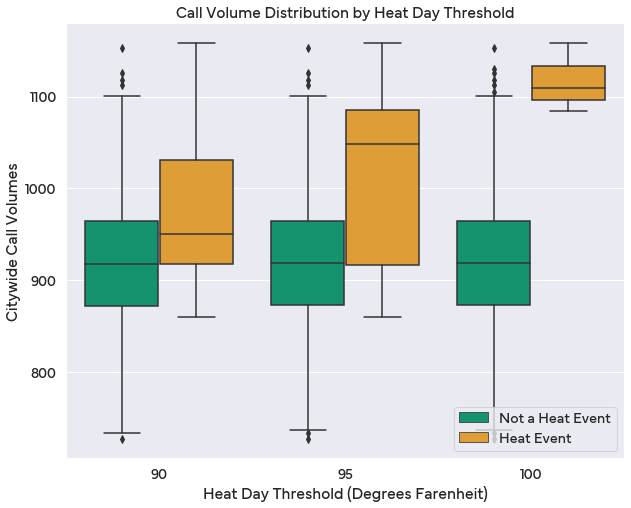

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=citywide_sens_df, x='heat_def', y='calls', hue='Day Type')

plt.xlabel('Heat Day Threshold (Degrees Farenheit)')
plt.ylabel('Citywide Call Volumes')
plt.title('Call Volume Distribution by Heat Day Threshold')
plt.legend(loc=4)
fig.savefig('../Final Graphics/Call Distribution.svg')
plt.show()

### Number of Heat days in Each District

In [59]:
districts_df = pd.read_csv('data/Analysis/90degreeheatday.csv', usecols= ['District','date_time','heat_index_high', 'calls', 'calls_per_10000'], parse_dates=['date_time'])
districts_gdf = gpd.read_file('data/LCVA/LCVA_pop.gpkg')

In [60]:
districts_df.head()

,District,date_time,heat_index_high,calls,calls_per_10000
0,1,2018-01-01,67.964050,9,2.392344
1,1,2018-01-02,75.183769,7,1.860712
2,1,2018-01-03,72.576000,5,1.329080
3,1,2018-01-04,72.901380,1,0.265816
4,1,2018-01-05,71.472715,6,1.594896


In [61]:
districts_gdf.head()

,OBJECTID,Fire_Districts_ObjectID,TOOLTIP,Battalion,Division,District,Battalion_,District_N,Children,OlderAdlts,...,Asthma,CardiovascularDisease,Disabled,No_Insurance,Livin,RentBurdened,Renter,Poverty,Population,geometry
0,1,1,Fire Battalion: 18\nFire Division: South Divis...,18,South Division,58,Battalion 18,District 58,20.322388,15.058550,...,30.241049,7.044495,8.909705,6.956533,1.019736,47.104152,58.728208,10.219914,50680.0,"MULTIPOLYGON (((-118.36743 34.06034, -118.3672..."
1,2,2,Fire Battalion: 9\nFire Division: North Divisi...,9,North Division,23,Battalion 9,District 23,17.358185,32.208253,...,11.349519,5.023098,10.420122,0.195947,0.027420,35.304516,16.392102,3.662628,8631.0,"MULTIPOLYGON (((-118.53778 34.11104, -118.5766..."
2,3,3,Fire Battalion: 2\nFire Division: South Divisi...,2,South Division,47,Battalion 2,District 47,24.277446,13.419303,...,52.762821,7.608830,11.402325,12.211653,0.668873,57.806577,51.393862,20.423344,35232.0,"MULTIPOLYGON (((-118.16056 34.08369, -118.1605..."
3,4,4,Fire Battalion: 2\nFire Division: South Divisi...,2,South Division,55,Battalion 2,District 55,20.974924,13.979066,...,46.421556,6.386763,11.027061,7.675542,4.294438,47.932924,43.841603,9.921914,31968.0,"MULTIPOLYGON (((-118.23008 34.13561, -118.2304..."
4,5,5,Fire Battalion: 4\nFire Division: South Divisi...,4,South Division,62,Battalion 4,District 62,19.061390,14.768529,...,32.469264,6.378599,9.076861,9.160902,0.487464,47.293083,58.140249,12.728911,55487.0,"MULTIPOLYGON (((-118.43229 34.02398, -118.4338..."


In [62]:
for threshold in thresholds:
    districts_df[str(threshold)] = districts_df['heat_index_high']>threshold

In [63]:
districts_df.head()

,District,date_time,heat_index_high,calls,calls_per_10000,90,95,100
0,1,2018-01-01,67.964050,9,2.392344,False,False,False
1,1,2018-01-02,75.183769,7,1.860712,False,False,False
2,1,2018-01-03,72.576000,5,1.329080,False,False,False
3,1,2018-01-04,72.901380,1,0.265816,False,False,False
4,1,2018-01-05,71.472715,6,1.594896,False,False,False


In [65]:
heat_calls_sum_df = districts_df.groupby('District').sum()[['calls', 'calls_per_10000', '90', '95', '100']]


<ipython-input-65-320594ad7a0a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  heat_calls_sum_df = districts_df.groupby('District').sum()[['calls', 'calls_per_10000', '90', '95', '100']]


In [66]:
districts_gdf['District'] = districts_gdf['District'].astype(int)

In [69]:
calls_and_days = districts_gdf[['District', 'geometry']].set_index('District').join(heat_calls_sum_df)
calls_and_days.to_file('data/Analysis/callsanddays.gpkg', driver='GPKG')

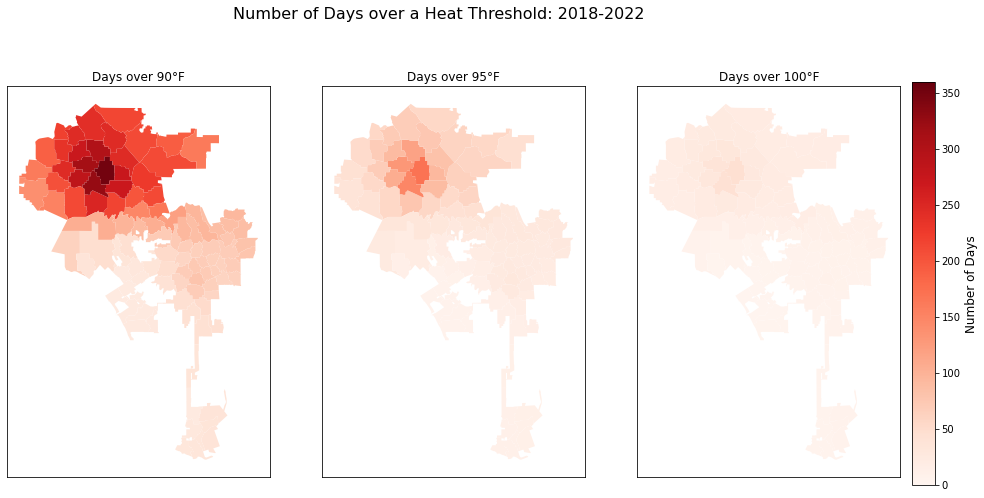

In [117]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))

#gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[20, 1], height_ratios=[1, 1], figure=fig, wspace=0.1, hspace=0.1)
# plot the first choropleth map in the first subplot
calls_and_days.plot(column='90', cmap=cmap, norm=norm, legend=False, ax=ax1)
ax1.set_title('Days over 90°F')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# plot the second choropleth map in the second subplot
calls_and_days.plot(column='95', cmap=cmap, norm=norm, legend=False, ax=ax2)
ax2.set_title('Days over 95°F')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
# plot the third choropleth map in the third subplot
calls_and_days.plot(column='100', cmap=cmap, norm=norm, legend=False, ax=ax3)
ax3.set_title('Days over 100°F')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# add a color ramp legend to the figure
ax4 = fig.add_axes([0.91, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # this is necessary for matplotlib 3.4 and later
cbar = fig.colorbar(sm, cax=ax4)
cbar.set_label('Number of Days', fontsize=12)
#cbar.ax.tick_params(labelsize=8)

# display the figure
fig.suptitle('Number of Days over a Heat Threshold: 2018-2022', fontsize=16)
plt.show()